In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.optimize import curve_fit

In [2]:
data_path = '../data/cfbd/games_1990_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
games_df_test = games_df[games_df.season<2015]
games_df_test = games_df_test[games_df.season>2010]
games_df_verify = games_df[games_df.season>=2015]
games_df.shape

<ipython-input-3-9b0ebddc986f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  games_df_test = games_df_test[games_df.season>2010]


(23256, 25)

In [4]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")
mean_and_error = lambda x: (np.mean(x), np.std(x)/(len(x) ** 2))
abs_mean_and_error = lambda x: (np.mean(np.abs(x)), np.std(x)/(len(x) ** 2))
abeError = lambda x: mean_and_error(np.abs(x))
date_from_cfbd = lambda x: datetime_from_cfbd(x).strftime('%Y-%m-%d')

In [5]:
def get_dates_df(df):
    date_dict = {}
    dates = df.start_date.to_numpy()
    dates_string = list(map(date_from_cfbd,dates))
    dates_string_list = []
    for date,date_string in zip(dates,dates_string):
        if date_string not in date_dict: 
            date_dict[date_string] = []
            dates_string_list.append(date_string)
            date_dict[date_string].append(date)
    return date_dict,dates_string_list

In [6]:
def make_preditiction(whr,date):
    at,ht,_,_,_,handicap = date
    away_rating, away_unc = whr.ratings_for_player(at,current=True)
    home_rating, home_unc = whr.ratings_for_player(ht,current=True)
    if away_rating and home_rating:
        return home_rating-away_rating+handicap, (away_unc ** 2 + home_unc **2 ) ** .5
    return None

In [7]:
def make_preditictions(whr,date_list):
    pred_list = []
    for at,ht,_,_,_,handicap in date_list:
        away_rating, away_unc = whr.ratings_for_player(at,current=True)
        home_rating, home_unc = whr.ratings_for_player(ht,current=True)
        if away_rating and home_rating:
            pred_list.append(home_rating-away_rating+handicap)
        else:
            pred_list.append(None)
    return pred_list

In [8]:
def compare_spread_prediction(whr, date_list):
    pred_list = []
    for date in date_list:
        _,_,ap,hp,dd,_ = date
        spread = hp-ap
        prediction = make_preditiction(whr,date)
        if not prediction==None:
            pred_list.append([spread,*prediction ,dd])
    return pred_list

In [9]:
def score_predictions(predictions, max_unc=100):
    abe_list = []
    correct_list = []
    for spread,pred,unc,_ in predictions:
        if unc > max_unc: continue
        abe_list.append(abs(spread-pred))
        correct_list.append(spread*pred>0)
    return mean_and_error(correct_list), abs_mean_and_error(abe_list)

In [10]:
def iterate_by_day(df,whr,handicap=2.5, time_offset=10, max_day_delta = 300,start_season=2020, max_pred=-1):
    
    df['date'] = df.start_date.apply(date_from_cfbd)
    date_list = np.unique(df['date'].to_numpy())
    first_date =  datetime.strptime(date_list[0],"%Y-%m-%d")

    day_delta = 0
    prediction_list = []
    for current_date in date_list:
        #after_offset =  day_delta > time_offset
        current_datetime = datetime.strptime(current_date,'%Y-%m-%d')
        after_offset = dt.date(year=current_datetime.year,month=current_datetime.month,day=1) >= dt.date(year=start_season,month=3,day=1)
       
        #before day
        if after_offset: 
            whr.auto_iterate(time_limit = 20, precision = 10E-4)
            
        #middle day
        day_delta = (current_datetime-first_date).days
        games_day = df[df.date==current_date]
        date_list = games_day[['away_team','home_team','away_points','home_points', 'neutral_site']].values.tolist()
        date_list = [[at,ht,ap,hp,day_delta,handicap*(1-ns)] for at,ht,ap,hp,ns in date_list]
        if after_offset:
            current_pred = compare_spread_prediction(whr, date_list)
            prediction_list+=current_pred
            #print(current_datetime, len(date_list),len(current_pred), score_predictions(current_pred))
            #print("\t\t\t",score_predictions(prediction_list))
        if max_pred > 0 and len(prediction_list) > max_pred: return prediction_list
        for game in date_list:
            whr.create_game(*game)
        #if max_day_delta> 0 and max_day_delta < day_delta: return prediction_list
    return prediction_list
        #end day

In [11]:
def benchmark_w2(df, default_w2,w2_short_term, verbose=False, time_offset=10, max_day_delta=-1,popt=[],start_season=2020, max_pred=-1):
    n_games = games_df_test.shape[0]
    n_iter_games = 0
    n_pred_games = 0
    correct_prediction_list = []
    delta_mov_list = []
    pred_list = []
    mov_list = []
    
    scale = 16
    mov_SF = 16/scale
    whr = whole_history_rating.Base({'scale': scale,'w2':default_w2,'w2_short_term':w2_short_term, 'debug':False})
    start_time = 0
    home_team_handicap = 2.5/13*scale
    current_day,day_delta=0,0
    
    pred_list = iterate_by_day(df,whr,start_season=start_season,max_pred=max_pred)

    return pred_list


In [20]:
start = time.perf_counter()
w2_list = []
per_corr_list = []
per_corr_unc_list = []
abe_list = []
abe_unc_list = []
mov_list_list = []
pred_mov_list_list = []
log_min, log_max = 1, 3
log_space = np.logspace(log_min, log_max,10)
lin_space = np.linspace(log_min, log_max,10)

log_min_short_term, log_max_short_term = .1, 1.
log_space_short_term = np.logspace(log_min_short_term, log_max_short_term,2)
lin_space_short_term = np.linspace(log_min_short_term, log_max_short_term,2)

for w2,w2_power in zip(log_space,lin_space):
    for w2_short_term,w2_power_short_term in zip(log_space_short_term,lin_space_short_term):
        print("w2 value: {} w2 short: {} w2 power: {} w2 short power: {}".format(w2,w2_short_term, w2_power,w2_power_short_term))
        predictions = benchmark_w2(games_df_verify,w2,w2_short_term, start_season=2017,max_pred=100)
        print(len(predictions))
        (correct, correct_err),(abe,abe_err) = score_predictions(predictions)

        w2_list.append([w2,w2_short_term])
        .append(correct)
        per_corr_unc_list.append(correct_err)
        abe_list.append(abe)
        abe_unc_list.append(abe_err)
        mid_time = time.perf_counter()
        print("{:.2f}% corr, abe: {:.2f}".format(correct*100,abe))
        print("{:.2f} seconds elapsed".format(mid_time-start))
end = time.perf_counter()
end-start

w2 value: 10.0 w2 short: 1.2589254117941673 w2 power: 1.0 w2 short power: 0.1


<ipython-input-10-864aaeca9286>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.start_date.apply(date_from_cfbd)


147
76.87% corr, abe: 16.04
48.01 seconds elapsed
w2 value: 10.0 w2 short: 10.0 w2 power: 1.0 w2 short power: 1.0
147
76.87% corr, abe: 16.17
95.95 seconds elapsed
w2 value: 16.68100537200059 w2 short: 1.2589254117941673 w2 power: 1.2222222222222223 w2 short power: 0.1
144
77.08% corr, abe: 16.15
141.41 seconds elapsed
w2 value: 16.68100537200059 w2 short: 10.0 w2 power: 1.2222222222222223 w2 short power: 1.0
143
76.92% corr, abe: 15.88
186.34 seconds elapsed
w2 value: 27.825594022071243 w2 short: 1.2589254117941673 w2 power: 1.4444444444444444 w2 short power: 0.1
141
78.72% corr, abe: 15.29
231.37 seconds elapsed
w2 value: 27.825594022071243 w2 short: 10.0 w2 power: 1.4444444444444444 w2 short power: 1.0
141
78.01% corr, abe: 15.25
275.47 seconds elapsed
w2 value: 46.41588833612777 w2 short: 1.2589254117941673 w2 power: 1.6666666666666665 w2 short power: 0.1
140
80.71% corr, abe: 15.53
319.90 seconds elapsed
w2 value: 46.41588833612777 w2 short: 10.0 w2 power: 1.6666666666666665 w2 sh

ZeroDivisionError: float division by zero

In [22]:
list(zip(w2_list,per_corr_list,abe_list))

[([10.0, 1.2589254117941673], 0.7687074829931972, 16.037414965986393),
 ([10.0, 10.0], 0.7687074829931972, 16.166666666666668),
 ([16.68100537200059, 1.2589254117941673],
  0.7708333333333334,
  16.15277777777778),
 ([16.68100537200059, 10.0], 0.7692307692307693, 15.884615384615385),
 ([27.825594022071243, 1.2589254117941673],
  0.7872340425531915,
  15.294326241134751),
 ([27.825594022071243, 10.0], 0.7801418439716312, 15.25177304964539),
 ([46.41588833612777, 1.2589254117941673], 0.8071428571428572, 15.525),
 ([46.41588833612777, 10.0], 0.8071428571428572, 15.567857142857143),
 ([77.4263682681127, 1.2589254117941673], 0.8, 15.824137931034484),
 ([77.4263682681127, 10.0], 0.8, 15.824137931034484)]

In [14]:
log_min, log_max = 1, 3
log_space = np.logspace(log_min, log_max,10)
lin_space = np.linspace(log_min, log_max,10)
list(zip(log_space,lin_space))

[(10.0, 1.0),
 (16.68100537200059, 1.2222222222222223),
 (27.825594022071243, 1.4444444444444444),
 (46.41588833612777, 1.6666666666666665),
 (77.4263682681127, 1.8888888888888888),
 (129.1549665014884, 2.111111111111111),
 (215.44346900318823, 2.333333333333333),
 (359.38136638046257, 2.5555555555555554),
 (599.4842503189409, 2.7777777777777777),
 (1000.0, 3.0)]

In [49]:
(correct, correct_err),(abe,abe_err)

((0.732824427480916, 2.578432411533063e-05),
 (16.904580152671755, 0.000694304073101533))

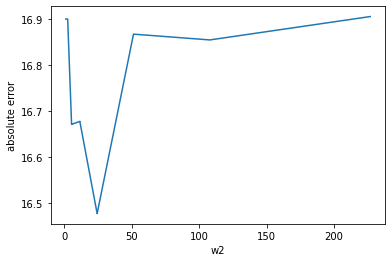

In [50]:
plt.errorbar(w2_list,abe_list,yerr=abe_unc_list)
plt.ylabel("absolute error")
plt.xlabel("w2")
plt.savefig("non_linear_prior_mov_abe_v_w2_{}_to_{}.png".format(log_min, log_max))

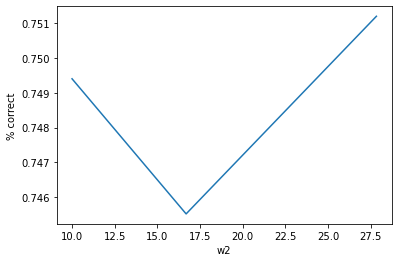

In [28]:
plt.errorbar(w2_list,per_corr_list,yerr=per_corr_unc_list)
plt.ylabel("% correct")
plt.xlabel("w2")
plt.savefig("non_linear_prior_mov_percent_corr_v_w2_{}_to_{}.png".format(log_min, log_max))

In [29]:
def linear_func(x,m,b):
    return m * x + b

In [30]:
spreads,preds,_,_ = zip(*predictions)
x,y = preds,spreads
popt,pcov = curve_fit(linear_func,x,y)
popt, pcov

(array([0.60567186, 6.17108478]),
 array([[ 0.00426033, -0.01391522],
        [-0.01391522,  1.39810632]]))

In [33]:
np.mean(np.abs(np.subtract(x,y)))

13.227272727272727

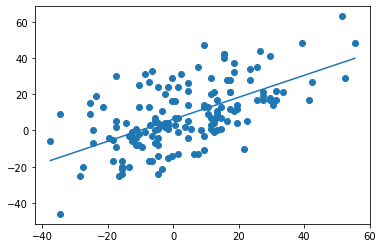

In [31]:
x_space = np.linspace(np.min(x), np.max(x),100)
y_pred = linear_func(x_space,*popt)
plt.scatter(x,y)
plt.plot(x_space,y_pred)